# ANDREW NG VIDEO TRANSLATION

I will try to modify an Andrew Ng video clip to match the audio of the same dialogue spoken by my Dad in "Indian English".

https://drive.google.com/open?id=1YFhE8Z6T1AK8l2UZ76c9e892sP6mf1sJ

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import numpy as np
import scipy.io.wavfile
import speechpy
import subprocess
import tqdm

# 1. Read input video

In [2]:
reader = imageio.get_reader('Andrew_Ng.mp4') 
video_fps = reader.get_meta_data()['fps']

In [3]:
print(len(reader), "frames -", video_fps, "fps -", len(reader)//video_fps, "secs")

180 frames - 15.0 fps - 12.0 secs


# 2. Read audio files

In [4]:
file_name = 'Andrew_Ng.wav'
fs, andrew_ng_audio = scipy.io.wavfile.read(file_name)
andrew_ng_audio = andrew_ng_audio[:,0]

In [5]:
print(len(andrew_ng_audio), "samples - ", len(andrew_ng_audio)//fs, "secs")

529967 samples -  12 secs


In [6]:
file_name = 'Nanna.wav'
fs, nanna_audio = scipy.io.wavfile.read(file_name)
nanna_audio = nanna_audio[:,0]

In [7]:
print(len(nanna_audio), "samples - ", len(nanna_audio)//fs, "secs")

652288 samples -  14 secs


# 3. Extract MFCC features

In [8]:
sampling_frequency = fs
frame_length = 0.025
frame_stride = 0.010
num_cepstral = 13
num_filters = 40

In [9]:
andrew_ng_audio_mfcc = speechpy.feature.mfcc(andrew_ng_audio, sampling_frequency=sampling_frequency,
                                             frame_length=frame_length, frame_stride=frame_stride,
                                             num_cepstral=num_cepstral, num_filters=num_filters)

In [10]:
nanna_audio_mfcc = speechpy.feature.mfcc(nanna_audio, sampling_frequency=fs,
                                         frame_length=frame_length, frame_stride=frame_stride,
                                         num_cepstral=num_cepstral, num_filters=num_filters)

In [11]:
print(andrew_ng_audio_mfcc.shape, nanna_audio_mfcc.shape)

(1200, 13) (1477, 13)


In [12]:
len(andrew_ng_audio)

529967

In [13]:
(frame_stride*sampling_frequency)

441.0

In [14]:
frame_length*sampling_frequency

1102.5

In [15]:
print(441*1199 + 1102.5, 441*1200 + 1102.5, 441*1201 + 1102.5, 441*1202 + 1102.5)

529861.5 530302.5 530743.5 531184.5


In [16]:
(len(andrew_ng_audio) - (frame_length*sampling_frequency))//(frame_stride*sampling_frequency) + 1

1200.0

In [17]:
(len(nanna_audio) - (frame_length*sampling_frequency))//(frame_stride*sampling_frequency) + 1

1477.0

In [18]:
1477*0.01*15

221.54999999999998

Thus, the MFCC calculator seems to append the audio samples with 0s to can cover all samples of audio.

# 4. Compare MFCC features of the two audio files, and get a mapping

# USING DYNAMIC PROGRAMMING

## "A Maximum Likelihood Stereo Algorithm" - Ingemar J. Cox, Sunita L. Hingorani, Satish B. Rao

https://pdfs.semanticscholar.org/b232/e3426e0014389ea05132ea8d08789dcc0566.pdf

In [19]:
input_x = andrew_ng_audio_mfcc
input_y = nanna_audio_mfcc

In [20]:
def cost(a, b):
    # Euclidean distance
    return np.linalg.norm(a - b)

In [21]:
# Initialize variables

init_cost = 5

# Cumulative cost
C = np.zeros((len(input_x)+1, len(input_y)+1))

for i in range(1, len(input_x)+1):
    C[i, 0] = i * init_cost

for j in range(1, len(input_y)+1):
    C[0, j] = j * init_cost
    
# Decider
M = np.zeros((len(input_x), len(input_y)))

In [22]:
# Compute cost and note the probable case
for i in tqdm.tqdm(range(1, len(input_x)+1)):
    for j in range(1, len(input_y)+1):
        min1 = C[i-1, j-1] + cost(input_x[i-1], input_y[j-1])
        min2 = C[i-1, j] + init_cost
        min3 = C[i, j-1] + init_cost
        C[i, j] = cmin = min(min1, min2, min3)
        if cmin == min1:
            M[i-1, j-1] = 1
        elif cmin == min2:
            M[i-1, j-1] = 2
        elif cmin == min3:
            M[i-1, j-1] = 3

100%|██████████| 1200/1200 [00:58<00:00, 20.39it/s]


In [23]:
# Track the actual mapping
x_to_y = np.zeros((len(input_x)))
y_to_x = np.zeros((len(input_y)))

p = len(input_x)
q = len(input_y)

while p != 0 and q != 0:
    if M[p-1, q-1] == 1:
        # p matches q
        x_to_y[p-1] = q-1
        y_to_x[q-1] = p-1
        p -= 1
        q -= 1
    elif M[p-1, q-1] == 2:
        # p is unmatched
        p -= 1
    elif M[p-1, q-1] == 3:
        # q is unmatched
        q -=1

In [24]:
y_to_x[-10:]

array([1183.,    0.,    0.,    0.,    0.,    0.,    0., 1199.,    0.,
          0.])

In [25]:
def fix_numbers(y_to_x):
    new_y_to_x = np.array(y_to_x).astype(float)
    start_idx = -1
    for i, num in enumerate(y_to_x[:-1]):
        if y_to_x[i+1] < y_to_x[i]:
            start_idx = i
        elif y_to_x[i+1] > y_to_x[i] and start_idx >= 0:
            end_idx = i + 1
            # print(start_idx, y_to_x[start_idx], end_idx, y_to_x[end_idx])
            new_range = np.linspace(y_to_x[start_idx], y_to_x[end_idx], end_idx - start_idx + 1)[:-1]
            # print(new_range)
            new_y_to_x[start_idx:end_idx] = new_range
            start_idx = -1
    if start_idx >= 0:
        new_y_to_x[start_idx:] = y_to_x[start_idx]
    return new_y_to_x

In [26]:
y_to_x_fixed = fix_numbers(y_to_x)

In [27]:
y_to_x_fixed[-10:]

array([1183.        , 1185.28571429, 1187.57142857, 1189.85714286,
       1192.14285714, 1194.42857143, 1196.71428571, 1199.        ,
       1199.        , 1199.        ])

In [28]:
np.save('y_to_x_fixed', y_to_x_fixed)

In [29]:
x_to_y_fixed = fix_numbers(x_to_y)

In [30]:
np.save('x_to_y_fixed', x_to_y_fixed)

# 5. Convert the mapping to video frames

In [31]:
target_video_frame_numbers_per_mfcc_sample = y_to_x_fixed * frame_stride * video_fps

In [32]:
target_video_frame_numbers_per_mfcc_sample[:10]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.3 ])

In [33]:
target_video_frame_numbers_per_mfcc_sample[-10:]

array([177.45      , 177.79285714, 178.13571429, 178.47857143,
       178.82142857, 179.16428571, 179.50714286, 179.85      ,
       179.85      , 179.85      ])

In [34]:
len(target_video_frame_numbers_per_mfcc_sample)

1477

In [35]:
num_of_video_frames = round(len(target_video_frame_numbers_per_mfcc_sample) * frame_stride * video_fps)
print(num_of_video_frames)

222


In [36]:
mfcc_frame_idx_of_video_frames = np.round(np.linspace(0, len(target_video_frame_numbers_per_mfcc_sample)-1, num_of_video_frames)).astype(int)

In [37]:
len(mfcc_frame_idx_of_video_frames), mfcc_frame_idx_of_video_frames

(222, array([   0,    7,   13,   20,   27,   33,   40,   47,   53,   60,   67,
          73,   80,   87,   94,  100,  107,  114,  120,  127,  134,  140,
         147,  154,  160,  167,  174,  180,  187,  194,  200,  207,  214,
         220,  227,  234,  240,  247,  254,  260,  267,  274,  281,  287,
         294,  301,  307,  314,  321,  327,  334,  341,  347,  354,  361,
         367,  374,  381,  387,  394,  401,  407,  414,  421,  427,  434,
         441,  447,  454,  461,  468,  474,  481,  488,  494,  501,  508,
         514,  521,  528,  534,  541,  548,  554,  561,  568,  574,  581,
         588,  594,  601,  608,  614,  621,  628,  634,  641,  648,  655,
         661,  668,  675,  681,  688,  695,  701,  708,  715,  721,  728,
         735,  741,  748,  755,  761,  768,  775,  781,  788,  795,  801,
         808,  815,  821,  828,  835,  842,  848,  855,  862,  868,  875,
         882,  888,  895,  902,  908,  915,  922,  928,  935,  942,  948,
         955,  962,  968,  975,  

In [38]:
target_video_frame_numbers = np.floor(target_video_frame_numbers_per_mfcc_sample[mfcc_frame_idx_of_video_frames]).astype(int)

In [39]:
target_video_frame_numbers

array([  0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1,   1,
         2,   2,   2,   3,   3,   4,   4,   5,   5,   5,   6,   6,   6,
         8,   9,  10,  12,  14,  15,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  27,  27,  27,  28,  30,  30,  31,  33,  35,  35,
        36,  37,  37,  38,  38,  39,  41,  44,  50,  50,  50,  51,  53,
        55,  55,  57,  58,  60,  62,  62,  62,  62,  62,  63,  63,  63,
        63,  64,  64,  65,  66,  66,  66,  67,  68,  69,  70,  70,  70,
        72,  72,  74,  74,  74,  74,  74,  74,  74,  74,  75,  75,  76,
        78,  79,  80,  80,  80,  84,  86,  86,  87,  87,  88,  94,  95,
        96,  97,  99,  99, 100, 102, 102, 104, 105, 107, 107, 107, 107,
       107, 108, 109, 111, 112, 112, 113, 113, 113, 113, 115, 116, 117,
       117, 118, 118, 119, 119, 119, 119, 120, 122, 124, 124, 126, 126,
       128, 129, 130, 132, 133, 135, 141, 142, 143, 145, 145, 147, 148,
       149, 149, 149, 152, 153, 153, 154, 155, 155, 155, 156, 15

# 6. Make new video

In [40]:
# Read video
reader = imageio.get_reader('Andrew_Ng.mp4')
frames_orig = []
for frame in reader:
    frames_orig.append(frame)

In [41]:
# Note new frames
new_frames = []
for source_frame_number in target_video_frame_numbers:
    new_frames.append(frames_orig[int(source_frame_number)])

In [42]:
# Save new video
imageio.mimwrite('/tmp/video.mp4', new_frames , fps=15)
command = ['ffmpeg', '-loglevel', 'error',
           '-i', '/tmp/video.mp4', '-i', 'Nanna.mp3', '-y',
           '-vcodec', 'libx264', '-preset', 'ultrafast', '-profile:v', 'main', '-acodec', 'aac', '-strict', '-2',
           'new_Andrew_Ng.mp4']
subprocess.call(command)

0

# That's all folks!

# --------------------------------------------------------------------------------------------------

# SCRATCHPAD

## [doesn't work] If frame numbers are fracions - Linearly combined in proportion

In [64]:
# Read video
reader = imageio.get_reader('Andrew_Ng.mp4')
frames_orig = []
for frame in reader:
    frames_orig.append(frame)

In [65]:
# Note new frames
new_frames = []
for source_frame_number in target_video_frame_numbers:
    if np.ceil(source_frame_number) != source_frame_number:
        new_frame = np.array(frames_orig[int(np.ceil(source_frame_number))]*(source_frame_number - np.floor(source_frame_number)) + frames_orig[int(np.floor(source_frame_number))]*(np.ceil(source_frame_number) - source_frame_number)).astype('uint8')
    else:
        new_frame = frames_orig[int(source_frame_number)]
    new_frames.append(new_frame)

In [66]:
# Write new video
imageio.mimwrite('/tmp/video.mp4', new_frames , fps=15)
command = ['ffmpeg', '-loglevel', 'error',
           '-i', '/tmp/video.mp4', '-i', 'Nanna.mp3', '-y',
           '-vcodec', 'libx264', '-preset', 'ultrafast', '-profile:v', 'main', '-acodec', 'aac', '-strict', '-2',
           'new_Andrew_Ng.mp4']
subprocess.call(command)

0

## "Depth Discontinuities by Pixel-to-Pixel Stereo" - Birchfield, Tomasi
https://users.cs.duke.edu/~tomasi/papers/tomasi/tomasiIjcv99.pdf

In [28]:
def euc_dist(a, b):
    return np.linalg.norm(a - b)

def disparity(x, y, input_x=andrew_ng_audio_mfcc, input_y=nanna_audio_mfcc):
    return euc_dist(input_x[x], input_y[y])

def update(d_p, y_p, d, y, phi, pi, m_x, input_x, input_y):
    # Kocc = the amount of evidence (in terms of mismatched pixel intensities)
    #        that is necessary in order to declare a change in disparity
    Kocc = 10.
    # Kr = maximum amount of pixel dissimilarity that is generally expected
    #      between two matching pixels
    Kr = 9.
    # Update
    phi_1 = phi[d_p, y_p] + disparity(y+d, y, input_x, input_y) - Kr + Kocc*int(d != d_p)
    if phi_1 < phi[d, y]:
        phi[d, y] = phi_1
        pi[d, y] = np.array([d_p, y_p])
        m_x[y+d] = min(m_x[y+d], phi_1)
    return phi, pi, m_x

In [30]:
input_x = andrew_ng_audio_mfcc
input_y = nanna_audio_mfcc
DELTA = 10

# Init phi
pi = np.zeros((DELTA+1, len(input_y)))
phi = -np.ones((DELTA+1, len(input_y)))
for d in range(DELTA+1):
    phi[d, 0] = disparity(d, 0, input_x, input_y)

# Init m_x
m_x = -np.ones((len(input_y)))

# Find v_L and v_R
# v_L is 1 to the left of the first big intensity variation (>10), 0 elsewhere,
# v_R is 1 to the right of the last big intensity variation (>10), 0 elsewhere
diffs_L = np.array([euc_dist(a, b) for a, b in zip( input_x, np.vstack(( input_x[0], input_x[:-1] )) )])
diffs_R = np.array([euc_dist(a, b) for a, b in zip( input_y, np.vstack(( input_y[0], input_y[:-1] )) )])
intensity_var_L = diffs_L > 10
intensity_var_R = diffs_R > 10
first_intensity_val_L = np.where(intensity_var_L == True)[0][0]
last_intensity_val_R = np.where(intensity_var_R == True)[0][-1]
v_L = np.zeros((len(input_x)))
v_L[:first_intensity_val_L] = 1
v_R = np.zeros((len(input_y)))
v_R[(last_intensity_val_R + 1):] = 1

# For y_p
for y_p in range(0, len(input_y)-2 + 1):
    m_y = min([phi[a, y_p] for a in range(0, DELTA + 1)])
    for d_p in range(0, DELTA + 1):
        update(d_p, y_p, d_p, y_p+1, phi, pi, m_x, input_x, input_y)
        if phi[d_p, y_p] <= m_y:
            y = y_p + 1
            for d in range(d_p+1, DELTA + 1):
                if v_L[y + d - 1]:
                    phi, pi, m_x = update(d_p, y_p, d, y, phi, pi, m_x, input_x, input_y)
        if phi[d_p, y_p] <= m_x[d_p + y_p] and v_R[y_p + 1]:
            for d in range(0, d_p-1 + 1):
                y = y_p + d_p - d + 1
                phi, pi, m_x = update(d_p, y_p, d, y, phi, pi, m_x, input_x, input_y)

ValueError: setting an array element with a sequence.

In [21]:
input_x = andrew_ng_audio_mfcc
input_y = nanna_audio_mfcc
DELTA = 3

# Init phi
phi = -np.ones((DELTA+1, len(input_y)))
for d in range(DELTA + 1):
    phi[d, 0] = disparity(d, 0, input_x, input_y)

# Init m_x
m_x = -np.ones((len(input_y)))

In [22]:
y_p = 0

In [23]:
min([phi[a, y_p] for a in range(0, DELTA + 1)])

11.101547344496852

In [ ]:
input_x = andrew_ng_audio_mfcc
input_y = nanna_audio_mfcc
DELTA = 3

# Init phi
phi = -np.ones((DELTA+1, len(input_y)))
for d in range(DELTA+1):
    phi[d, 0] = disparity(d, 0, input_x, input_y)

# Init m_x
m_x = -np.ones((len(input_y)))

In [30]:
# Find v_L and v_R
v_L_tmp = np.array([np.linalg.norm(a) for a in input_x])
v_L = v_L_tmp - np.vstack((np.zeros((v_L_tmp.shape[1])), v_L_tmp[:-1]))

IndexError: tuple index out of range

In [37]:
v_L_tmp

array([15.11045334, 17.30897316, 16.9655468 , ..., 17.84893282,
       17.0416946 , 18.36130872])

In [39]:
np.vstack((np.zeros((len(v_L_tmp), v_L_tmp[:-1]))))

TypeError: only integer scalar arrays can be converted to a scalar index

In [21]:
d = 10
d_p = 10
int(d != d_p)

0

In [38]:
np.where(intensity_var_L == True)[0][0]

25

In [31]:
diffs_R

[0.0,
 8.814022774103492,
 6.40016715934424,
 7.240072298788084,
 4.870929981831926,
 7.3726863155601325,
 4.340443620031712,
 4.793731979734545,
 4.307834954151268,
 3.8872890889033114,
 8.22351809748693,
 8.401158415006995,
 5.5933007636931675,
 4.643547041496125,
 4.048999416119325,
 4.580309375261242,
 4.206205376542679,
 5.157543188572214,
 5.130428358948492,
 5.531117715352508,
 4.748652873263856,
 4.935240649756562,
 6.821756851620016,
 4.917195427842875,
 7.556227891775517,
 4.530765408440276,
 4.052127218292127,
 3.70741839572489,
 7.860601958712031,
 6.492713474615631,
 5.1048066791038265,
 5.035114779334411,
 4.874961375708802,
 4.430234188812346,
 4.648784542357658,
 5.336941482507535,
 5.050976151500548,
 3.5458880927182816,
 4.426648404655194,
 4.005295583979386,
 5.541934102636434,
 5.177743277702727,
 6.777556451588981,
 6.005567378984828,
 4.941707965426905,
 6.714081280158234,
 7.858452146400792,
 5.748550427632372,
 3.7643665532599537,
 3.386587007978271,
 6.59802287

# NAIVE METHOD

## 4.1. Finding the euclidean distances between all pairs of frames in a brute-force method:

In [21]:
def euc_dist(v1, v2):
    '''Euclidean distance between two (column) vectors v1 and v2'''
    return np.dot(v1.T, v2)

In [22]:
dists = np.zeros((len(andrew_ng_audio_mfcc), len(nanna_audio_mfcc)))

for i in tqdm.tqdm(range(len(andrew_ng_audio_mfcc))):
    for j in range(len(nanna_audio_mfcc)):
        dists[i, j] = euc_dist(andrew_ng_audio_mfcc[i].T, nanna_audio_mfcc[j].T)

100%|██████████| 1200/1200 [00:09<00:00, 126.67it/s]


Text(0,0.5,'andrew_ng')

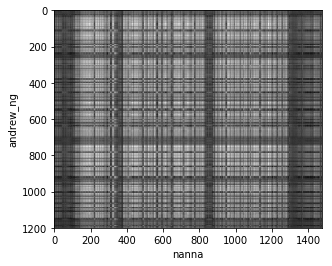

In [23]:
plt.imshow(dists, cmap='gray', vmin=dists.min(), vmax=dists.max())
plt.xlabel("nanna")
plt.ylabel("andrew_ng")

## 4.2. Isolating the distances between all frames in source audio and only the 100 frames around that time in the target audio

In [24]:
local_dists = dists.max()*np.ones((len(dists), 100))
for i in range(len(andrew_ng_audio_mfcc)):
    min_index = max(0, i-50)
    max_index = min(len(nanna_audio_mfcc)-1, i+50)
    local_dists_at_i = dists[i][min_index:max_index]
    if len(local_dists_at_i) < 100:
        if min_index == 0:
            local_dists[i][-len(local_dists_at_i):] = local_dists_at_i
        else:
            local_dists[i][:len(local_dists_at_i)] = local_dists_at_i
    else:
        local_dists[i] = local_dists_at_i

Text(0,0.5,'andrew_ng')

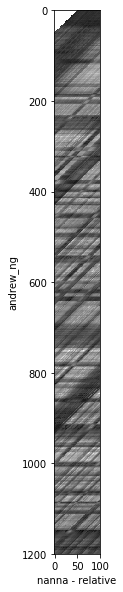

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(local_dists, cmap='gray', vmin=local_dists.min(), vmax=local_dists.max())
plt.xlabel("nanna - relative")
plt.ylabel("andrew_ng")

## 4.3. Finding the indices of the frame numbers in the target audio that are least distant to each frame in the source audio, within 100 frames around that source audio frame

In [26]:
local_time_maps = np.argmin(local_dists, axis=1)

In [27]:
local_time_maps[:200]

array([50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34,
       33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 81, 73, 18, 78,
       77, 69, 75, 67, 73, 65, 64, 63, 62, 61, 60, 66, 65, 57, 63, 55, 61,
        2,  1,  0, 42, 49, 48, 54, 46, 45, 44, 43, 49, 48, 40, 46, 38, 37,
       36, 42, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 19, 22, 21, 20,
       19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5, 11,  3,
        2,  1,  0,  6, 39, 38, 42, 41, 40, 39, 38, 37, 46, 35, 34, 33, 32,
       31, 20, 19, 18, 17, 16, 15,  5, 13,  3, 11,  1,  9, 13,  7, 19, 18,
       17, 16, 15, 14, 13,  7, 11, 10,  9,  3,  7,  6,  5,  4,  3,  2,  1,
        0,  1,  1,  0,  5,  4,  3,  2,  1,  0,  0,  0,  5, 23, 26, 21, 25,
       99, 99, 99, 99, 99, 98, 99, 98, 97, 96,  9,  7, 11, 92, 91,  4,  2,
        1,  0,  0,  0, 84, 83, 82, 81, 80, 79, 78, 64, 63])

In [28]:
global_time_maps = np.array([local_time_maps[i]-50+i for i in range(len(local_time_maps))])

In [73]:
global_time_maps[-200:]

array([ 993,  993,  997,  997,  993,  997,  997,  999, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1068, 1068, 1071, 1026, 1026, 1026, 1026, 1026,
       1026, 1083, 1083, 1083, 1026, 1083, 1083, 1083, 1083, 1083, 1083,
       1026, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083,
       1083, 1026, 1068, 1083, 1026, 1068, 1068, 1068, 1068, 1068, 1068,
       1068, 1068, 1045, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083,
       1083, 1083, 1083, 1083, 1130, 1131, 1130, 1083, 1068, 1068, 1068,
       1068, 1136, 1136, 1136, 1141, 1136, 1136, 1068, 1068, 1141, 1136,
       1136, 1136, 1136, 1141, 1068, 1068, 1068, 1068, 1068, 1068, 1068,
       1068, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1137, 1136,
       1137, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1135,
       1135, 1135, 1136, 1136, 1136, 1136, 1136, 1136, 1135, 1135, 1136,
       1136, 1136, 1164, 1164, 1161, 1161, 1161, 11

Checking if the numbers are in ascending order:

In [30]:
np.sum([global_time_maps[i+1] < global_time_maps[i] for i in range(len(global_time_maps)-1)])

191

Text(0.5,1,'Audio frame numbers in target')

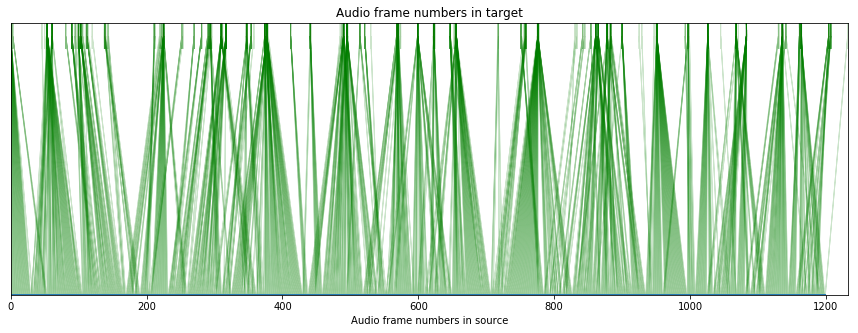

In [31]:
mapping = global_time_maps
fig = plt.figure(figsize=(15, 5))
plt.plot(list(range(len(mapping))), [0]*len(mapping))
plt.ylim([0, 1.05])
plt.xlim([0, mapping.max()])
for i in range(len(mapping)):
    plt.gca().arrow(i, 0, mapping[i]-i, 1, head_width=0.1, head_length=0.1, fc='r', ec='g', alpha=0.2)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel("Audio frame numbers in source")
plt.title("Audio frame numbers in target")

## 4.4. Taking the median of those target audio frame numbers to smooth them

In [68]:
def smooth_global_time_maps(global_time_maps, median_window):
    global_time_maps_smoothed = np.zeros((len(global_time_maps) - median_window))
    for i in range(len(global_time_maps) - median_window):
        global_time_maps_smoothed[i] = np.median(global_time_maps[i:i+median_window])
    global_time_maps_smoothed = np.concatenate(([global_time_maps_smoothed[0]]*(median_window//2),
                                                global_time_maps_smoothed,
                                                [global_time_maps_smoothed[-1]]*(median_window//2))).astype(int)
    return global_time_maps_smoothed

In [69]:
def plot_time_maps(mapping, median_window):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(list(range(len(mapping))), [0]*len(mapping), label="median_window = "+str(median_window))
    plt.legend()
    plt.ylim([0, 1.05])
    plt.xlim([0, mapping.max()])
    for i in range(len(mapping)):
        plt.gca().arrow(i, 0, mapping[i]-i, 1, head_width=0.1, head_length=0.1, fc='r', ec='g', alpha=0.2)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.xlabel("Audio frame numbers in source")
    plt.title("Audio frame numbers in target")

- ### median_window = 10

In [70]:
median_window = 10
global_time_maps_smoothed_10 = smooth_global_time_maps(global_time_maps, median_window)

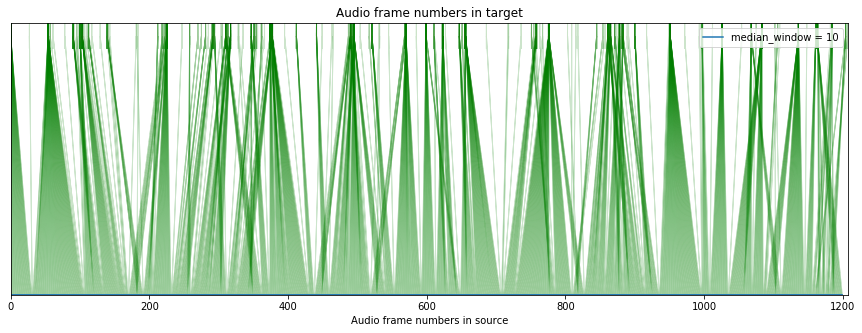

In [71]:
plot_time_maps(global_time_maps_smoothed_10, median_window)

In [72]:
global_time_maps_smoothed_10

array([   0,    0,    0, ..., 1163, 1163, 1163])

Checking if the numbers are all in ascending order:

In [36]:
np.sum([global_time_maps_smoothed_10[i+1] < global_time_maps_smoothed_10[i] for i in range(len(global_time_maps_smoothed_10)-1)])

70

Seeing the number of unique target values:

In [74]:
len(np.unique(global_time_maps_smoothed_10))

163

- ### median_window = 50

In [75]:
median_window = 50
global_time_maps_smoothed_50 = smooth_global_time_maps(global_time_maps, median_window)

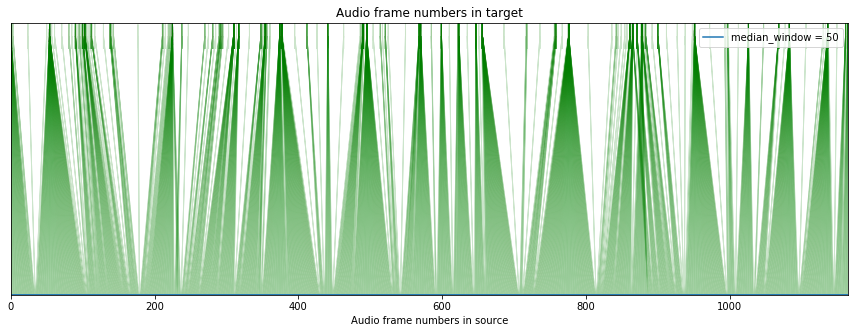

In [76]:
plot_time_maps(global_time_maps_smoothed_50, median_window)

Checking if the numbers are all in ascending order:

In [77]:
np.sum([global_time_maps_smoothed_50[i+1] < global_time_maps_smoothed_50[i] for i in range(len(global_time_maps_smoothed_50)-1)])

6

Seeing the number of unique target values:

In [41]:
len(np.unique(global_time_maps_smoothed_50))

161

- ### median_window = 100

In [42]:
median_window = 100
global_time_maps_smoothed_100 = smooth_global_time_maps(global_time_maps, median_window)

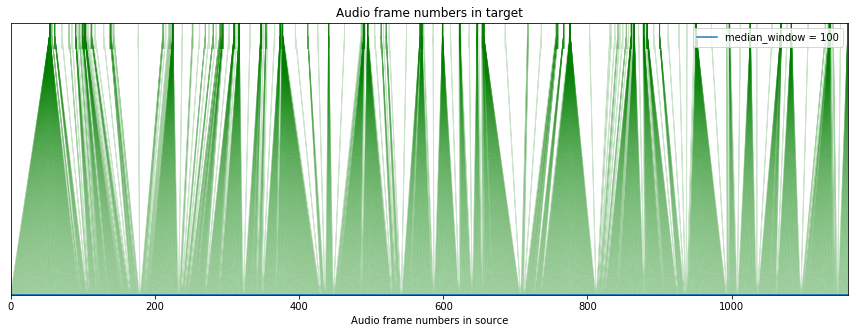

In [43]:
plot_time_maps(global_time_maps_smoothed_100, median_window)

Checking if the numbers are all in ascending order:

In [44]:
np.sum([global_time_maps_smoothed_100[i+1] < global_time_maps_smoothed_100[i] for i in range(len(global_time_maps_smoothed_100)-1)])

0

In [45]:
len(np.unique(global_time_maps_smoothed_100))

168

- ### Choose

Hence, let us choose global_time_maps_smoothed_100 (median_window = 100), since it has no criss-cross mappings.

In [46]:
global_time_maps_smoothed = global_time_maps_smoothed_100

## 4.5. Get mapping of frames in video

Get all mapped video_frame_numbers from all mapped audio_frame_numbers: 

In [104]:
target_video_frame_numbers = np.round(global_time_maps_smoothed * frame_stride * video_fps).astype(int)

In [105]:
target_video_frame_numbers

array([  8,   8,   8, ..., 174, 174, 174])

Get the key_frames_in_target_video as the unique set of all mapped target_video_frame_numbers:

In [106]:
key_frames_in_target_video = np.unique(target_video_frame_numbers)

In [107]:
key_frames_in_target_video

array([  8,   9,  11,  12,  13,  14,  15,  16,  17,  18,  19,  21,  27,
        32,  33,  34,  36,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  50,  52,  53,  55,  56,  57,  59,  62,  64,  66,  69,
        73,  74,  76,  77,  78,  79,  82,  85,  86,  88,  90,  92,  93,
        94,  95,  97,  98, 103, 108, 110, 113, 114, 115, 116, 120, 125,
       126, 127, 128, 129, 130, 131, 132, 134, 135, 137, 139, 141, 142,
       143, 146, 149, 150, 152, 154, 155, 158, 160, 162, 166, 170, 171,
       173, 174])

Get the corresponding key_frames_in_source_video:

First, extract all those frames in source video that correspond to each key frame in target video:

In [108]:
key_frames_in_source_video_dict = { target_key_frame : np.where(target_video_frame_numbers == target_key_frame) for target_key_frame in key_frames_in_target_video }

In [109]:
key_frames_in_source_video_dict

{8: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
         85, 86, 87, 88, 89, 90, 91, 92, 93, 94]),),
 9: (array([ 95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105]),),
 11: (array([106]),),
 12: (array([107, 108]),),
 13: (array([109]),),
 14: (array([110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]),),
 15: (array([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
         136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
         149, 150, 151, 152]),),
 16: (array([153, 154, 155, 156]),),
 17: (array([157, 158, 159, 160, 161, 162, 163, 164]),),
 18: (array([165]),),
 19: (array([166]),),
 21: (array(

Then, take the median of all source video frames corresponding to each key_frame_in_target_video, to get the corresponding key_frame_in_source_video:

In [110]:
key_frames_in_source_video = np.round([ np.median(key_frames_in_source_video_dict[key_frame_in_target_video])*frame_stride*video_fps for key_frame_in_target_video in key_frames_in_source_video_dict ]).astype(int)

In [111]:
key_frames_in_source_video

array([  7,  15,  16,  16,  16,  17,  21,  23,  24,  25,  25,  26,  27,
        27,  28,  32,  35,  35,  36,  36,  36,  37,  37,  39,  40,  42,
        43,  46,  48,  50,  52,  52,  54,  60,  64,  65,  65,  66,  67,
        68,  74,  79,  80,  81,  81,  81,  82,  86,  88,  91,  93,  95,
        96,  96,  97, 102, 106, 106, 107, 107, 108, 110, 116, 122, 122,
       122, 123, 123, 125, 129, 132, 135, 139, 140, 140, 140, 141, 141,
       145, 149, 149, 150, 151, 153, 155, 155, 157, 162, 164, 168, 172,
       172, 176])

# 5. Get new frame numbers in target video

In [112]:
key_frames_in_source_video

array([  7,  15,  16,  16,  16,  17,  21,  23,  24,  25,  25,  26,  27,
        27,  28,  32,  35,  35,  36,  36,  36,  37,  37,  39,  40,  42,
        43,  46,  48,  50,  52,  52,  54,  60,  64,  65,  65,  66,  67,
        68,  74,  79,  80,  81,  81,  81,  82,  86,  88,  91,  93,  95,
        96,  96,  97, 102, 106, 106, 107, 107, 108, 110, 116, 122, 122,
       122, 123, 123, 125, 129, 132, 135, 139, 140, 140, 140, 141, 141,
       145, 149, 149, 150, 151, 153, 155, 155, 157, 162, 164, 168, 172,
       172, 176])

In [113]:
key_frames_in_target_video

array([  8,   9,  11,  12,  13,  14,  15,  16,  17,  18,  19,  21,  27,
        32,  33,  34,  36,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  50,  52,  53,  55,  56,  57,  59,  62,  64,  66,  69,
        73,  74,  76,  77,  78,  79,  82,  85,  86,  88,  90,  92,  93,
        94,  95,  97,  98, 103, 108, 110, 113, 114, 115, 116, 120, 125,
       126, 127, 128, 129, 130, 131, 132, 134, 135, 137, 139, 141, 142,
       143, 146, 149, 150, 152, 154, 155, 158, 160, 162, 166, 170, 171,
       173, 174])

In [114]:
total_number_of_target_frames = int(np.round(len(nanna_audio)/fs*video_fps))
target_video_has_source_frame_numbers = np.zeros(total_number_of_target_frames)

In [115]:
key_frames_in_source_video = np.concatenate(([0], key_frames_in_source_video, [len(reader) - 1])) 
key_frames_in_target_video = np.concatenate(([0], key_frames_in_target_video, [total_number_of_target_frames - 1]))

In [116]:
key_frames_in_source_video

array([  0,   7,  15,  16,  16,  16,  17,  21,  23,  24,  25,  25,  26,
        27,  27,  28,  32,  35,  35,  36,  36,  36,  37,  37,  39,  40,
        42,  43,  46,  48,  50,  52,  52,  54,  60,  64,  65,  65,  66,
        67,  68,  74,  79,  80,  81,  81,  81,  82,  86,  88,  91,  93,
        95,  96,  96,  97, 102, 106, 106, 107, 107, 108, 110, 116, 122,
       122, 122, 123, 123, 125, 129, 132, 135, 139, 140, 140, 140, 141,
       141, 145, 149, 149, 150, 151, 153, 155, 155, 157, 162, 164, 168,
       172, 172, 176, 179])

In [117]:
key_frames_in_target_video

array([  0,   8,   9,  11,  12,  13,  14,  15,  16,  17,  18,  19,  21,
        27,  32,  33,  34,  36,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  50,  52,  53,  55,  56,  57,  59,  62,  64,  66,
        69,  73,  74,  76,  77,  78,  79,  82,  85,  86,  88,  90,  92,
        93,  94,  95,  97,  98, 103, 108, 110, 113, 114, 115, 116, 120,
       125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 137, 139, 141,
       142, 143, 146, 149, 150, 152, 154, 155, 158, 160, 162, 166, 170,
       171, 173, 174, 221])

In [169]:
for k in range(1, len(key_frames_in_source_video)):
    from_source_video_frame = key_frames_in_source_video[k-1]
    to_source_video_frame = key_frames_in_source_video[k]
    from_target_video_frame = key_frames_in_target_video[k-1]
    to_target_video_frame = key_frames_in_target_video[k]
    number_of_target_frames = to_target_video_frame - from_target_video_frame
    if from_source_video_frame != to_source_video_frame:
        new_source_video_frames_to_place_in_target_video = np.arange(from_source_video_frame,
                                                                     to_source_video_frame,
                                                                     (to_source_video_frame - from_source_video_frame)/number_of_target_frames)
        target_video_has_source_frame_numbers[from_target_video_frame:to_target_video_frame] = new_source_video_frames_to_place_in_target_video[:number_of_target_frames]
    else:
        target_video_has_source_frame_numbers[from_target_video_frame:to_target_video_frame] = np.array([to_source_video_frame]*number_of_target_frames)

target_video_has_source_frame_numbers[-1] = key_frames_in_source_video[-1]

In [174]:
target_video_has_source_frame_numbers

array([  0.        ,   0.875     ,   1.75      ,   2.625     ,
         3.5       ,   4.375     ,   5.25      ,   6.125     ,
         7.        ,  15.        ,  15.5       ,  16.        ,
        16.        ,  16.        ,  17.        ,  21.        ,
        23.        ,  24.        ,  25.        ,  25.        ,
        25.5       ,  26.        ,  26.16666667,  26.33333333,
        26.5       ,  26.66666667,  26.83333333,  27.        ,
        27.        ,  27.        ,  27.        ,  27.        ,
        27.        ,  28.        ,  32.        ,  33.5       ,
        35.        ,  35.        ,  35.        ,  36.        ,
        36.        ,  36.        ,  37.        ,  37.        ,
        39.        ,  40.        ,  42.        ,  43.        ,
        46.        ,  47.        ,  48.        ,  49.        ,
        50.        ,  52.        ,  52.        ,  52.        ,
        54.        ,  60.        ,  62.        ,  64.        ,
        64.33333333,  64.66666667,  65.        ,  65.  

# 6. Make new frames

In [192]:
frames_orig = []
for frame in reader:
    frames_orig.append(frame)

In [178]:
len(frames)

180

In [207]:
new_frames = []
for frame_orig, source_frame_number in zip(frames_orig, target_video_has_source_frame_numbers):
    if np.ceil(source_frame_number) != source_frame_number:
        new_frame = np.array(frames_orig[int(np.ceil(source_frame_number))]*(source_frame_number - np.floor(source_frame_number)) + frames_orig[int(np.floor(source_frame_number))]*(np.ceil(source_frame_number) - source_frame_number)).astype('uint8')
    else:
        new_frame = frames_orig[int(source_frame_number)]
    new_frames.append(new_frame)

In [208]:
imageio.mimwrite('/tmp/video.mp4', new_frames , fps=15)

In [210]:
import subprocess
command = ['ffmpeg', '-loglevel', 'error',
           '-i', '/tmp/video.mp4', '-i', 'Nanna.mp3',
           '-vcodec', 'libx264', '-preset', 'ultrafast', '-profile:v', 'main', '-acodec', 'aac', '-strict', '-2',
           'new_Andrew_Ng.mp4']
subprocess.call(command)

0